In [0]:
!mkdir output_images
!mkdir frames
!mkdir animations
!pip install imageio

In [0]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import numpy as np
img_name = "ILSVRC2012_test_00031441.JPEG"
model = VGG16()
image = load_img(img_name, target_size=(224, 224))
image = img_to_array(image)
images = np.zeros((1, 224, 224, 3))
images[0, :, :, :] = image[:, :, :]
images = preprocess_input(images)
predictions = model.predict(images)
labels = decode_predictions(predictions)
print labels

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
[[(u'n02088632', u'bluetick', 0.9981552), (u'n02088364', u'beagle', 0.00051322614), (u'n02100236', u'German_short-haired_pointer', 0.000492395), (u'n02089867', u'Walker_hound', 0.00042497576), (u'n02108000', u'EntleBucher', 9.478738e-05)]]


rm: cannot remove 'output_images/*': No such file or directory
rm: cannot remove 'frames/*': No such file or directory


Using TensorFlow backend.


96


AttributeError: ignored

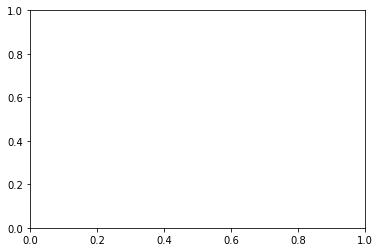

In [0]:
!rm output_images/*
!rm frames/*
from skimage.transform import resize
from skimage.segmentation import slic, felzenszwalb
from skimage.util import img_as_float
from skimage import io
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras import backend as K
from explain import explain
import matplotlib.pyplot as plt
import imageio
import matplotlib.colors as mcolors
import tensorflow as tf
import numpy as np
import cv2
import random
numSegments = 100
path = "output_images/"
img_name = "dog.jpg"
object_label = "beagle"
cut_off = 0.90
images_anim = []
image1 = img_as_float(io.imread(img_name))
original_image_dims = image1.shape
def plot_function(iteration, l_vals, u_vals):
  return
  final_image = np.zeros((224, 224, 3), dtype = "uint8")
  final_image[:, :, :] = image[:, :, :]
  for i in range(numSegments):
    if l_vals[i] < (1.0 / 3):
      final_image[masks[i, :, :], :] = 255
  cv2.imwrite("frames/" + str(iteration) + ".jpg", cv2.cvtColor(final_image, cv2.COLOR_RGB2BGR))
  images_anim.append(imageio.imread("frames/" + str(iteration) + ".jpg"))
#img_as_float(cv2.resize(io.imread(img_name), (224, 224)))
#segments = slic(image1, n_segments = 200, sigma = 0.1)
segments = felzenszwalb(image1, scale = 100, sigma = 0.5, min_size = numSegments)

#for i in range(224):
#  for j in range(224):
#    segments[i, j] = i*224 + j
#slic(image1, n_segments = numSegments, sigma = 5)
numSegments = np.max(segments) + 1
print numSegments
#model = VGG16()
#model.summary()
image = load_img(img_name, target_size=(224, 224))
image = img_to_array(image)
orig_image = load_img(img_name)
orig_image = img_to_array(orig_image)
masks = np.zeros((numSegments, original_image_dims[0], original_image_dims[1]), dtype = bool)
for i in range(numSegments):
  masks[i, :, :] = (segments == i)
class image_class(explain):
  iteration = -1
  def sampling(self, num_sampled_points):
    self.iteration += 1
    if (self.iteration % 1000 == 0):
      #sample_points(num_sampled_points, self.temp_l_vec_values)
      sample_points_1(num_sampled_points)
    #samples = np.random.randint(2, size = (num_sampled_points, numSegments))
    #odds = [1] * 50 + [2] * 40 + [3] * 10
    #indices = np.random.randint(1, total_points, (num_sampled_points))
    #indices[0] = 0
    #return input_for_explanations[indices, :], class_labels[indices]
    return input_for_explanations, class_labels
def sample_points_2(num_sampled_points):
  global input_for_explanations, class_labels
  samples = np.ones((num_sampled_points, numSegments))
  for i in range(numSegments):
    for j in range(int(num_sampled_points / numSegments)):
      samples[np.random.randint(0, num_sampled_points), i] = 0
  #for i in range(num_sampled_points):
  #  for j in range(int(0.1 * numSegments)):
  #    samples[i, random.randint(0, numSegments - 1)] = 0
  samples[0, :] = 1
  input_for_explanations = samples[:, :] * (1.0 / 3) + (1.0 / 3)
  images = np.zeros((num_sampled_points, 224, 224, 3))
  samples_boolean = samples.astype(bool)
  for i in range(num_sampled_points):
    images[i, :, :, :] = image[:, :, :]
    images[i, np.any(masks[~samples_boolean[i, :], :, :], 0), :] = 0
  images = preprocess_input(images)

  #all_predictions = np.zeros((num_sampled_points, 1000))
  #for i in range(0, num_sampled_points, 100):
  #  all_predictions[i:i+100, :] = model.predict(images[i:i+100, :, :, :])
  all_predictions = model.predict(images)
  labels = decode_predictions(all_predictions)
  class_labels = np.zeros((num_sampled_points, ))
  for i in range(num_sampled_points):
    for j in range(len(labels[i])):
      if labels[i][j][1] == object_label and labels[i][j][2] >= cut_off:
        class_labels[i] = 1
        break
def sample_points_1(num_sampled_points):
  global input_for_explanations, class_labels
  samples = np.ones((num_sampled_points, numSegments))
  for i in range(num_sampled_points):
    #parameters_to_be_flipped = np.random.choice(numSegments, int(0.35 * numSegments), replace = False)
    #samples[i, parameters_to_be_flipped] = 1 - samples[i, parameters_to_be_flipped]
    for j in range(int(0.35 * numSegments)):
      samples[i, random.randint(0, numSegments - 1)] = 0
  samples[0, :] = 1
  input_for_explanations = samples[:, :] * (1.0 / 3) + (1.0 / 3)
  images = np.zeros((num_sampled_points, 224, 224, 3))
  samples_boolean = samples.astype(bool)
  for i in range(num_sampled_points):
    images[i, :, :, :] = image[:, :, :]
    images[i, cv2.resize(np.any(masks[~samples_boolean[i, :], :, :], 0).astype(float), (224, 224), interpolation = 0).astype(bool), :] = 0
  images = preprocess_input(images)

  #all_predictions = np.zeros((num_sampled_points, 1000))
  #for i in range(0, num_sampled_points, 100):
  #  all_predictions[i:i+100, :] = model.predict(images[i:i+100, :, :, :])
  all_predictions = model.predict(images)
  labels = decode_predictions(all_predictions)
  class_labels = np.zeros((num_sampled_points, ))
  for i in range(num_sampled_points):
    for j in range(len(labels[i])):
      if labels[i][j][1] == object_label and labels[i][j][2] >= cut_off:
        class_labels[i] = 1
        break
def sample_points(num_sampled_points, l_vec):
  global input_for_explanations, class_labels
  samples = np.ones((num_sampled_points, numSegments))
  for i in range(numSegments):
    if l_vec[i] < (1.0 / 3):
      samples[0:(num_sampled_points), i] = np.random.randint(0, 2, ((num_sampled_points), ))
      #samples[(num_sampled_points/2):num_sampled_points, i] = 0
  for i in range(num_sampled_points / 2):
    parameters_to_be_flipped = np.random.choice(numSegments, np.random.randint(1, int(0.5 * numSegments)))
    samples[i, parameters_to_be_flipped] = 1 - samples[i, parameters_to_be_flipped]
    #np.random.randint(1, int(0.05 * numSegments))
    #parameters_to_be_flipped = np.random.choice(numSegments, 1)
    #samples[i, parameters_to_be_flipped] = 1 - samples[i, parameters_to_be_flipped]
    #for j in range(random.randint(1, int(0.3 * numSegments))):
    #  segmentNumber = random.randint(0, numSegments - 1)
    #  samples[i, segmentNumber] = 1 - samples[i, segmentNumber]
  samples[0, :] = 1
  input_for_explanations = np.zeros((num_sampled_points, numSegments))
  input_for_explanations[:, :] = samples[:, :] * (1.0 / 3) + (1.0 / 3)
  images = np.zeros((num_sampled_points, 224, 224, 3))
  samples_boolean = samples.astype(bool)
  for i in range(num_sampled_points):
    images[i, :, :, :] = image[:, :, :]
    images[i, cv2.resize(np.any(masks[~samples_boolean[i, :], :, :], 0).astype(float), (224, 224), interpolation = 0).astype(bool), :] = 0
  images = preprocess_input(images)

  all_predictions = np.zeros((num_sampled_points, 1000))
  for i in range(0, num_sampled_points, 100):
    all_predictions[i:i+100, :] = model.predict(images[i:i+100, :, :, :])
  labels = decode_predictions(all_predictions)
  class_labels = np.zeros((num_sampled_points, ))
  for i in range(num_sampled_points):
    for j in range(len(labels[i])):
      if labels[i][j][1] == object_label and labels[i][j][2] >= cut_off:
        class_labels[i] = 1
        break
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for run in range(1):
  image_object = image_class(np.ones(numSegments, ) * (2.0 / 3), 1000, np.array([[1]]), 100, 100, 0.95, plot_function)
  model = VGG16()
  image_object.fit_explanation(5000)
  final_image = np.zeros((original_image_dims[0], original_image_dims[1], 3), dtype = "uint8")
  final_image[:, :, :] = orig_image[:, :, :]
  test_image = np.zeros((224, 224, 3))
  test_image[:, :, :] = image[:, :, :]
  for i in range(numSegments):
    if image_object.l_vec_values[i] < (1.0 / 3):
      final_image[masks[i, :, :], :] = 255
      test_image[cv2.resize(masks[i, :, :].astype(float), (224, 224), interpolation = 0).astype(bool), :] = 0
  test_images = np.zeros((1, 224, 224, 3))
  test_images[0, :, :, :] = test_image[:, :, :]
  test_images = preprocess_input(test_images)
  print decode_predictions(model.predict(test_images))
  valid_superpixels = np.ones((numSegments, ), dtype = bool)
  valid_superpixels[image_object.l_vec_values < (1.0 / 3)] = 0
  cv2.imwrite(path + str(run) + "_Explanation.jpg", cv2.cvtColor(final_image, cv2.COLOR_RGB2BGR))
  superpixel_removal_order = image_object.greedy_select(numSegments, list(valid_superpixels))
  map_importance = np.zeros((original_image_dims[0], original_image_dims[1]))
  for i in range(len(superpixel_removal_order)):
    map_importance[segments == superpixel_removal_order[i]] = (i + 1) * 1.0 / len(superpixel_removal_order)
  heatmap = cv2.applyColorMap(np.uint8(255 * (1 - map_importance)), cv2.COLORMAP_JET)
  image_plus_heatmap = cv2.addWeighted(np.uint8(orig_image), 0.2, heatmap, 0.8, 0)
  ax.imshow(image_plus_heatmap / 255.0)
  plt.axis("off")
  plt.savefig(path + str(run) + "_Heat_Map.jpg", bbox_inches = "tight")
  points_graph = 10
  images_for_prediction_anchor = np.zeros(((len(superpixel_removal_order) + 1) * points_graph, 224, 224, 3))
  images_for_prediction_random = np.zeros(((len(superpixel_removal_order) + 1) * points_graph, 224, 224, 3))
  x_anchor = []
  x_random = []
  y_anchor = []
  y_random = []
  for i in range(0, len(superpixel_removal_order) + 1):
    for j in range(0, points_graph):
      images_for_prediction_anchor[i * points_graph + j, :, :, :] = image[:, :, :]
      images_for_prediction_random[i * points_graph + j, :, :, :] = image[:, :, :]
      random_superpixels = np.random.choice(numSegments, i, replace = False)
      anchor_superpixels = np.random.choice(superpixel_removal_order, i, replace = False)
      for k in anchor_superpixels:
        images_for_prediction_anchor[i * points_graph + j, cv2.resize(masks[k, :, :].astype(float), (224, 224), interpolation = 0).astype(bool), :] = 0
      for k in random_superpixels:
        images_for_prediction_random[i * points_graph + j, cv2.resize(masks[k, :, :].astype(float), (224, 224), interpolation = 0).astype(bool), :] = 0
  images_for_prediction_anchor = preprocess_input(images_for_prediction_anchor)
  images_for_prediction_random = preprocess_input(images_for_prediction_random)
  predictions_anchor = model.predict(images_for_prediction_anchor)
  predictions_random = model.predict(images_for_prediction_random)
  decoded_anchor = decode_predictions(predictions_anchor, top = 1000)
  decoded_random = decode_predictions(predictions_random, top = 1000)
  for i in range(0, len(superpixel_removal_order) + 1):
    for j in range(0, points_graph):
      x_anchor.append(i)
      for k in decoded_anchor[i * points_graph + j]:
        if k[1] == object_label:
          y_anchor.append(k[2])
          break
  for i in range(0, len(superpixel_removal_order) + 1):
    for j in range(0, points_graph):
      x_random.append(i)
      for k in decoded_random[i * points_graph + j]:
        if k[1] == object_label:
          y_random.append(k[2])
          break
  y_anchor_mean = []
  x_mean = []
  y_random_mean = []
  y_anchor_std = []
  y_random_std = []
  i = 0
  while i < len(y_anchor):
    y_anchor_mean.append(np.mean(y_anchor[i:i + points_graph]))
    y_random_mean.append(np.mean(y_random[i:i + points_graph]))
    y_anchor_std.append(np.std(y_anchor[i:i + points_graph]))
    y_random_std.append(np.std(y_random[i:i + points_graph]))
    x_mean.append(i / points_graph)
    i += points_graph
  fig = plt.figure()
  ax = fig.add_subplot(1, 1, 1)
  (_, caps, _) = plt.errorbar(x_mean, y_anchor_mean, y_anchor_std, marker = "o", color = "red", capsize = 5)
  for cap in caps:
    cap.set_markeredgewidth(1)
  (_, caps, _) = plt.errorbar(x_mean, y_random_mean, y_random_std, marker = "o", color = "blue", capsize = 5)
  for cap in caps:
    cap.set_markeredgewidth(1)
  plt.axis("on")
  plt.savefig(path + str(run) + "_Probability.jpg", bbox_inches = "tight")
  points_graph = 1
  images_for_prediction_anchor = np.zeros(((len(superpixel_removal_order) + 1) * points_graph, 224, 224, 3))
  images_for_prediction_random = np.zeros(((len(superpixel_removal_order) + 1) * points_graph, 224, 224, 3))
  x_anchor = []
  y_anchor = []
  import copy
  superpixel_reverse = copy.deepcopy(superpixel_removal_order)
  superpixel_reverse.reverse()
  for i in range(0, len(superpixel_removal_order) + 1):
    for j in range(0, points_graph):
      images_for_prediction_anchor[i * points_graph + j, :, :, :] = image[:, :, :]
      anchor_superpixels = superpixel_reverse[0:i]
      for k in anchor_superpixels:
        images_for_prediction_anchor[i * points_graph + j, cv2.resize(masks[k, :, :].astype(float), (224, 224), interpolation = 0).astype(bool), :] = 0
  images_for_prediction_anchor = preprocess_input(images_for_prediction_anchor)
  predictions_anchor = model.predict(images_for_prediction_anchor)
  decoded_anchor = decode_predictions(predictions_anchor, top = 1000)
  for i in range(0, len(superpixel_removal_order) + 1):
    for j in range(0, points_graph):
      x_anchor.append(i)
      for k in decoded_anchor[i * points_graph + j]:
        if k[1] == object_label:
          y_anchor.append(k[2])
          break
  fig = plt.figure()
  ax = fig.add_subplot(1, 1, 1)
  plt.plot(x_anchor, y_anchor, marker = "o")
  plt.axis("on")
  plt.savefig(path + str(run) + "_Greedy.jpg", bbox_inches = "tight")
  tf.reset_default_graph()
  K.clear_session()
imageio.mimsave("animations/animation.gif", images_anim, loop = 1)

rm: cannot remove 'frames/*': No such file or directory
96

Iteration      Loss                  Cov                   Prec                  Analytic Cov          Analytic Prec         
1              -0.0865297164101      0.0865297164101       0.277013781654        0.001                 1.0                   
1001           -0.961901640176       0.961901640176        0.265754042193        0.005                 1.0                   
2001           -0.967922897995       0.967922897995        0.274648098772        0.026                 1.0                   
3001           -26.7270755186        0.970110658652        0.257569648599        0.082                 0.865853658537        
4001           -0.967290251196       0.967290251196        0.257729457702        0.023                 0.95652173913         
[[(u'n02088364', u'beagle', 0.6927857), (u'n02088238', u'basset', 0.08321467), (u'n02099712', u'Labrador_retriever', 0.047706343), (u'n02089867', u'Walker_hound', 0.027891692), (u'n020

RuntimeError: ignored

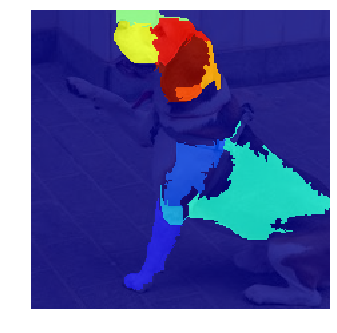

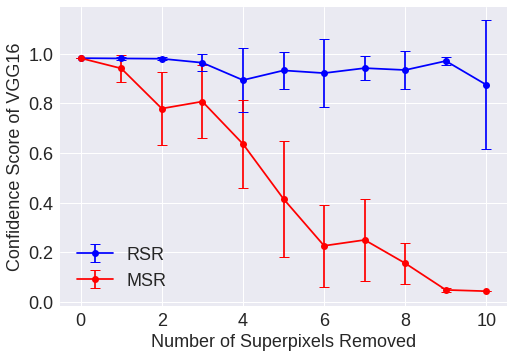

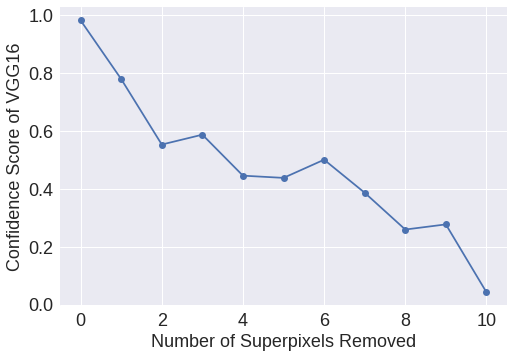

In [0]:
!rm output_images/*
!rm frames/*
from skimage.transform import resize
from skimage.segmentation import slic, felzenszwalb
from skimage.util import img_as_float
from skimage import io
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras import backend as K
from explain_viz import explain
import matplotlib.pyplot as plt
import imageio
import matplotlib.colors as mcolors
import tensorflow as tf
import numpy as np
import cv2
import random
numSegments = 100
path = "output_images/"
img_name = "dog.jpg"
object_label = "beagle"
cut_off = 0.90
images_anim = []
image1 = img_as_float(io.imread(img_name))
original_image_dims = image1.shape
def plot_function(iteration, l_vals, u_vals):
  return
  final_image = np.zeros((224, 224, 3), dtype = "uint8")
  final_image[:, :, :] = image[:, :, :]
  for i in range(numSegments):
    if l_vals[i] < (1.0 / 3):
      final_image[masks[i, :, :], :] = 255
  cv2.imwrite("frames/" + str(iteration) + ".jpg", cv2.cvtColor(final_image, cv2.COLOR_RGB2BGR))
  images_anim.append(imageio.imread("frames/" + str(iteration) + ".jpg"))
#img_as_float(cv2.resize(io.imread(img_name), (224, 224)))
#segments = slic(image1, n_segments = 200, sigma = 0.1)
segments = felzenszwalb(image1, scale = 100, sigma = 0.5, min_size = numSegments)

#for i in range(224):
#  for j in range(224):
#    segments[i, j] = i*224 + j
#slic(image1, n_segments = numSegments, sigma = 5)
numSegments = np.max(segments) + 1
print numSegments
#model = VGG16()
#model.summary()
image = load_img(img_name, target_size=(224, 224))
image = img_to_array(image)
orig_image = load_img(img_name)
orig_image = img_to_array(orig_image)
masks = np.zeros((numSegments, original_image_dims[0], original_image_dims[1]), dtype = bool)
for i in range(numSegments):
  masks[i, :, :] = (segments == i)
class image_class(explain):
  iteration = -1
  def sampling(self, num_sampled_points):
    self.iteration += 1
    if (self.iteration % 1000 == 0):
      #sample_points(num_sampled_points, self.temp_l_vec_values)
      sample_points_1(num_sampled_points)
    #samples = np.random.randint(2, size = (num_sampled_points, numSegments))
    #odds = [1] * 50 + [2] * 40 + [3] * 10
    #indices = np.random.randint(1, total_points, (num_sampled_points))
    #indices[0] = 0
    #return input_for_explanations[indices, :], class_labels[indices]
    return input_for_explanations, class_labels
def sample_points_2(num_sampled_points):
  global input_for_explanations, class_labels
  samples = np.ones((num_sampled_points, numSegments))
  for i in range(numSegments):
    for j in range(int(num_sampled_points / numSegments)):
      samples[np.random.randint(0, num_sampled_points), i] = 0
  #for i in range(num_sampled_points):
  #  for j in range(int(0.1 * numSegments)):
  #    samples[i, random.randint(0, numSegments - 1)] = 0
  samples[0, :] = 1
  input_for_explanations = samples[:, :] * (1.0 / 3) + (1.0 / 3)
  images = np.zeros((num_sampled_points, 224, 224, 3))
  samples_boolean = samples.astype(bool)
  for i in range(num_sampled_points):
    images[i, :, :, :] = image[:, :, :]
    images[i, np.any(masks[~samples_boolean[i, :], :, :], 0), :] = 0
  images = preprocess_input(images)

  #all_predictions = np.zeros((num_sampled_points, 1000))
  #for i in range(0, num_sampled_points, 100):
  #  all_predictions[i:i+100, :] = model.predict(images[i:i+100, :, :, :])
  all_predictions = model.predict(images)
  labels = decode_predictions(all_predictions)
  class_labels = np.zeros((num_sampled_points, ))
  for i in range(num_sampled_points):
    for j in range(len(labels[i])):
      if labels[i][j][1] == object_label and labels[i][j][2] >= cut_off:
        class_labels[i] = 1
        break
def sample_points_1(num_sampled_points):
  global input_for_explanations, class_labels
  samples = np.ones((num_sampled_points, numSegments))
  for i in range(num_sampled_points):
    #parameters_to_be_flipped = np.random.choice(numSegments, int(0.35 * numSegments), replace = False)
    #samples[i, parameters_to_be_flipped] = 1 - samples[i, parameters_to_be_flipped]
    for j in range(int(0.35 * numSegments)):
      samples[i, random.randint(0, numSegments - 1)] = 0
  samples[0, :] = 1
  input_for_explanations = samples[:, :] * (1.0 / 3) + (1.0 / 3)
  images = np.zeros((num_sampled_points, 224, 224, 3))
  samples_boolean = samples.astype(bool)
  for i in range(num_sampled_points):
    images[i, :, :, :] = image[:, :, :]
    images[i, cv2.resize(np.any(masks[~samples_boolean[i, :], :, :], 0).astype(float), (224, 224), interpolation = 0).astype(bool), :] = 0
  images = preprocess_input(images)

  #all_predictions = np.zeros((num_sampled_points, 1000))
  #for i in range(0, num_sampled_points, 100):
  #  all_predictions[i:i+100, :] = model.predict(images[i:i+100, :, :, :])
  all_predictions = model.predict(images)
  labels = decode_predictions(all_predictions)
  class_labels = np.zeros((num_sampled_points, ))
  for i in range(num_sampled_points):
    for j in range(len(labels[i])):
      if labels[i][j][1] == object_label and labels[i][j][2] >= cut_off:
        class_labels[i] = 1
        break
def sample_points(num_sampled_points, l_vec):
  global input_for_explanations, class_labels
  samples = np.ones((num_sampled_points, numSegments))
  for i in range(numSegments):
    if l_vec[i] < (1.0 / 3):
      samples[0:(num_sampled_points), i] = np.random.randint(0, 2, ((num_sampled_points), ))
      #samples[(num_sampled_points/2):num_sampled_points, i] = 0
  for i in range(num_sampled_points / 2):
    parameters_to_be_flipped = np.random.choice(numSegments, np.random.randint(1, int(0.5 * numSegments)))
    samples[i, parameters_to_be_flipped] = 1 - samples[i, parameters_to_be_flipped]
    #np.random.randint(1, int(0.05 * numSegments))
    #parameters_to_be_flipped = np.random.choice(numSegments, 1)
    #samples[i, parameters_to_be_flipped] = 1 - samples[i, parameters_to_be_flipped]
    #for j in range(random.randint(1, int(0.3 * numSegments))):
    #  segmentNumber = random.randint(0, numSegments - 1)
    #  samples[i, segmentNumber] = 1 - samples[i, segmentNumber]
  samples[0, :] = 1
  input_for_explanations = np.zeros((num_sampled_points, numSegments))
  input_for_explanations[:, :] = samples[:, :] * (1.0 / 3) + (1.0 / 3)
  images = np.zeros((num_sampled_points, 224, 224, 3))
  samples_boolean = samples.astype(bool)
  for i in range(num_sampled_points):
    images[i, :, :, :] = image[:, :, :]
    images[i, cv2.resize(np.any(masks[~samples_boolean[i, :], :, :], 0).astype(float), (224, 224), interpolation = 0).astype(bool), :] = 0
  images = preprocess_input(images)

  all_predictions = np.zeros((num_sampled_points, 1000))
  for i in range(0, num_sampled_points, 100):
    all_predictions[i:i+100, :] = model.predict(images[i:i+100, :, :, :])
  labels = decode_predictions(all_predictions)
  class_labels = np.zeros((num_sampled_points, ))
  for i in range(num_sampled_points):
    for j in range(len(labels[i])):
      if labels[i][j][1] == object_label and labels[i][j][2] >= cut_off:
        class_labels[i] = 1
        break
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for run in range(1):
  image_object = image_class(np.ones(numSegments, ) * (2.0 / 3), 1000, np.array([[1]]), 100, 100, 0.95, plot_function)
  model = VGG16()
  image_object.fit_explanation(5000)
  final_image = np.zeros((original_image_dims[0], original_image_dims[1], 3), dtype = "uint8")
  final_image[:, :, :] = orig_image[:, :, :]
  test_image = np.zeros((224, 224, 3))
  test_image[:, :, :] = image[:, :, :]
  for i in range(numSegments):
    if image_object.l_vec_values[i] < (1.0 / 3):
      final_image[masks[i, :, :], :] = 255
      test_image[cv2.resize(masks[i, :, :].astype(float), (224, 224), interpolation = 0).astype(bool), :] = 0
  test_images = np.zeros((1, 224, 224, 3))
  test_images[0, :, :, :] = test_image[:, :, :]
  test_images = preprocess_input(test_images)
  print decode_predictions(model.predict(test_images))
  valid_superpixels = np.ones((numSegments, ), dtype = bool)
  valid_superpixels[image_object.l_vec_values < (1.0 / 3)] = 0
  cv2.imwrite(path + str(run) + "_Explanation.jpg", cv2.cvtColor(final_image, cv2.COLOR_RGB2BGR))
  superpixel_removal_order = image_object.greedy_select(numSegments, list(valid_superpixels))
  map_importance = np.zeros((original_image_dims[0], original_image_dims[1]))
  for i in range(len(superpixel_removal_order)):
    map_importance[segments == superpixel_removal_order[i]] = (i + 1) * 1.0 / len(superpixel_removal_order)
  heatmap = cv2.applyColorMap(np.uint8(255 * (1 - map_importance)), cv2.COLORMAP_JET)
  image_plus_heatmap = cv2.addWeighted(np.uint8(orig_image), 0.2, heatmap, 0.8, 0)
  ax.imshow(image_plus_heatmap / 255.0)
  plt.axis("off")
  plt.savefig(path + str(run) + "_Heat_Map.jpg", bbox_inches = "tight")
  points_graph = 10
  images_for_prediction_anchor = np.zeros(((len(superpixel_removal_order) + 1) * points_graph, 224, 224, 3))
  images_for_prediction_random = np.zeros(((len(superpixel_removal_order) + 1) * points_graph, 224, 224, 3))
  x_anchor = []
  x_random = []
  y_anchor = []
  y_random = []
  for i in range(0, len(superpixel_removal_order) + 1):
    for j in range(0, points_graph):
      images_for_prediction_anchor[i * points_graph + j, :, :, :] = image[:, :, :]
      images_for_prediction_random[i * points_graph + j, :, :, :] = image[:, :, :]
      random_superpixels = np.random.choice(numSegments, i, replace = False)
      anchor_superpixels = np.random.choice(superpixel_removal_order, i, replace = False)
      for k in anchor_superpixels:
        images_for_prediction_anchor[i * points_graph + j, cv2.resize(masks[k, :, :].astype(float), (224, 224), interpolation = 0).astype(bool), :] = 0
      for k in random_superpixels:
        images_for_prediction_random[i * points_graph + j, cv2.resize(masks[k, :, :].astype(float), (224, 224), interpolation = 0).astype(bool), :] = 0
  images_for_prediction_anchor = preprocess_input(images_for_prediction_anchor)
  images_for_prediction_random = preprocess_input(images_for_prediction_random)
  predictions_anchor = model.predict(images_for_prediction_anchor)
  predictions_random = model.predict(images_for_prediction_random)
  decoded_anchor = decode_predictions(predictions_anchor, top = 1000)
  decoded_random = decode_predictions(predictions_random, top = 1000)
  for i in range(0, len(superpixel_removal_order) + 1):
    for j in range(0, points_graph):
      x_anchor.append(i)
      for k in decoded_anchor[i * points_graph + j]:
        if k[1] == object_label:
          y_anchor.append(k[2])
          break
  for i in range(0, len(superpixel_removal_order) + 1):
    for j in range(0, points_graph):
      x_random.append(i)
      for k in decoded_random[i * points_graph + j]:
        if k[1] == object_label:
          y_random.append(k[2])
          break
  y_anchor_mean = []
  x_mean = []
  y_random_mean = []
  y_anchor_std = []
  y_random_std = []
  i = 0
  while i < len(y_anchor):
    y_anchor_mean.append(np.mean(y_anchor[i:i + points_graph]))
    y_random_mean.append(np.mean(y_random[i:i + points_graph]))
    y_anchor_std.append(np.std(y_anchor[i:i + points_graph]))
    y_random_std.append(np.std(y_random[i:i + points_graph]))
    x_mean.append(i / points_graph)
    i += points_graph
  fig = plt.figure()
  ax = fig.add_subplot(1, 1, 1)
  plt.ylabel("Confidence Score of VGG16", fontsize = 18)
  plt.xlabel("Number of Superpixels Removed", fontsize = 18)
  for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(18) 
  for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(18)
  (_, caps, _) = plt.errorbar(x_mean, y_random_mean, y_random_std, marker = "o", color = "blue", capsize = 5)
  for cap in caps:
    cap.set_markeredgewidth(1)
  (_, caps, _) = plt.errorbar(x_mean, y_anchor_mean, y_anchor_std, marker = "o", color = "red", capsize = 5)
  for cap in caps:
    cap.set_markeredgewidth(1)
  ax.legend(["RSR", "MSR"], fontsize = 18)
  plt.axis("on")
  plt.savefig(path + str(run) + "_Probability.pdf", bbox_inches = "tight")
  points_graph = 1
  images_for_prediction_anchor = np.zeros(((len(superpixel_removal_order) + 1) * points_graph, 224, 224, 3))
  images_for_prediction_random = np.zeros(((len(superpixel_removal_order) + 1) * points_graph, 224, 224, 3))
  x_anchor = []
  y_anchor = []
  import copy
  superpixel_reverse = copy.deepcopy(superpixel_removal_order)
  superpixel_reverse.reverse()
  for i in range(0, len(superpixel_removal_order) + 1):
    for j in range(0, points_graph):
      images_for_prediction_anchor[i * points_graph + j, :, :, :] = image[:, :, :]
      anchor_superpixels = superpixel_reverse[0:i]
      for k in anchor_superpixels:
        images_for_prediction_anchor[i * points_graph + j, cv2.resize(masks[k, :, :].astype(float), (224, 224), interpolation = 0).astype(bool), :] = 0
  images_for_prediction_anchor = preprocess_input(images_for_prediction_anchor)
  predictions_anchor = model.predict(images_for_prediction_anchor)
  decoded_anchor = decode_predictions(predictions_anchor, top = 1000)
  for i in range(0, len(superpixel_removal_order) + 1):
    for j in range(0, points_graph):
      x_anchor.append(i)
      for k in decoded_anchor[i * points_graph + j]:
        if k[1] == object_label:
          y_anchor.append(k[2])
          break
  fig = plt.figure()
  ax = fig.add_subplot(1, 1, 1)
  plt.plot(x_anchor, y_anchor, marker = "o")
  plt.ylabel("Confidence Score of VGG16", fontsize = 18)
  plt.xlabel("Number of Superpixels Removed", fontsize = 18)
  for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(18) 
  for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(18)
  plt.axis("on")
  plt.savefig(path + str(run) + "_Greedy.pdf", bbox_inches = "tight")
  tf.reset_default_graph()
  K.clear_session()
imageio.mimsave("animations/animation.gif", images_anim, loop = 1)

In [0]:
xp = np.zeros((224, 224, 3))
xp[:, :, :] = image[:, :, :]
xp[cv2.resize(masks[0, :, :].astype(float), (224, 224), interpolation = 0).astype(bool), :] = 0
model = VGG16()
image_xp = img_to_array(xp)
images_xp = np.zeros((1, 224, 224, 3))
images_xp[0, :, :, :] = image_xp[:, :, :]
images_xp = preprocess_input(images_xp)
predictions = model.predict(images_xp)
labels = decode_predictions(predictions)
xp_save = np.zeros((500, 500, 3), dtype = "uint8")
xp_save[:, :, :] = image1[:, :, :]
xp_save[masks[0, :, :], :] = 255
cv2.imwrite("Snow.jpg", cv2.cvtColor(xp_save, cv2.COLOR_RGB2BGR))
print labels

[[(u'n01795545', u'black_grouse', 0.25314182), (u'n01798484', u'prairie_chicken', 0.10970135), (u'n02088632', u'bluetick', 0.10286375), (u'n03888257', u'parachute', 0.05073037), (u'n01943899', u'conch', 0.033077028)]]


In [0]:
imageio.mimsave("animations/animation_endless.gif", images_anim, loop = 0)